# Referencia a la implementación

https://towardsdatascience.com/an-efficient-implementation-of-dbscan-on-pyspark-3e2be646f57d/

# Instalación

In [1]:
!python --version

Python 3.11.11


In [2]:
import numpy as np
from scipy.spatial import distance
from rtree import index


import numpy as np
import pandas as pd
from rtree import index
from collections import deque
from queue import PriorityQueue
import math

In [3]:
import pyspark.sql.functions as sql_f
from pyspark.sql import SparkSession

cores = 14

spark = (
    SparkSession.builder.master(f"local[{cores}]")
    .appName(f"Local DT con {cores} particiones")
    .config("spark.driver.memory", "16g")
    .config("spark.executor.memory", "16g")
    .getOrCreate()
)
sc = spark.sparkContext
# La linea de abajo debería incluirse en la configuración de Spark para usar GraphFrames
# .config("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.4-s_2.12") \

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/22 03:54:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark.version

'3.5.5'

# Carga de datos

In [5]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType


# Lectura del dataset
df = spark.read.format('csv') \
    .option('header', 'true') \
    .option('delimiter', ',') \
    .load('spotify_songs.csv') \
    .repartition(10)

# Lista de columnas a convertir
cols_to_convert = [
    "track_popularity", "danceability", "energy", "key", "loudness", "mode",
    "speechiness", "acousticness", "instrumentalness", "liveness", "valence",
    "tempo", "duration_ms"
]

# Castea las columnas especificadas a DoubleType
for c in cols_to_convert:
    df = df.withColumn(c, col(c).cast(DoubleType()))
    

# Filtrado de géneros incorrectos
valid_genres = ['pop', 'rock', 'rap', 'edm', 'r&b', 'latin']
df = df.filter(col('playlist_genre').isin(valid_genres))
df.select('playlist_genre').distinct().show()
print("Número de géneros únicos:", df.select('playlist_genre').distinct().count())

cols_to_drop = [
    'track_id', 'track_name', 'track_artist', 
    'track_album_id', 'track_album_name', 
    'playlist_name', 'playlist_id'
]

df = df.drop(*cols_to_drop).cache()

+--------------+
|playlist_genre|
+--------------+
|           r&b|
|           pop|
|           edm|
|           rap|
|          rock|
|         latin|
+--------------+

Número de géneros únicos: 6


In [6]:
from pyspark.sql.functions import col, substring
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

categorical_cols = ['playlist_genre']


def one_hot_preprocess(df, categorical_cols):

    indexers = [StringIndexer(inputCol=col, outputCol=col +
                              '_idx', handleInvalid='keep') for col in categorical_cols]
    encoders = [OneHotEncoder(
        inputCol=col + '_idx', outputCol=col + '_ohe') for col in categorical_cols]

    pipeline = Pipeline(stages=indexers + encoders)
    return pipeline.fit(df).transform(df)

In [7]:
categorical_cols = ['playlist_genre']
df = one_hot_preprocess(df, categorical_cols= categorical_cols)

from pyspark.sql.functions import substring

# Extraer el año de la fecha (formato 'YYYY-MM-DD')
df = df.withColumn("release_year", substring("track_album_release_date", 1, 4).cast("int"))

df = df.drop('playlist_genre', 'playlist_subgenre', 'track_album_release_date')

In [8]:
categorical_cols = ['playlist_genre']
idx_cols = [col + '_idx' for col in categorical_cols]
df = df.drop(*idx_cols)

In [9]:
from pyspark.sql.functions import size, col
from pyspark.ml.functions import vector_to_array

# Convertir vectores a arrays
df = df.withColumn("playlist_genre_array", vector_to_array("playlist_genre_ohe"))
# df = df.withColumn("playlist_subgenre_array", vector_to_array("playlist_subgenre_ohe"))

# Obtener tamaños
genre_length = df.select(size("playlist_genre_array").alias("size")).first()["size"]
# subgenre_length = df.select(size("playlist_subgenre_array").alias("size")).first()["size"]

# Usar los tamaños directamente en los loops
for i in range(genre_length):
    df = df.withColumn(f"playlist_genre_{i}", col("playlist_genre_array").getItem(i))

# for i in range(subgenre_length):
    # df = df.withColumn(f"playlist_subgenre_{i}", col("playlist_subgenre_array").getItem(i))

In [10]:
# Eliminar las variables redundantes
df = df.drop('playlist_genre_ohe', 'playlist_genre_array')

In [11]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

assembler = VectorAssembler(inputCols=df.columns, outputCol="features")
df = assembler.transform(df)

# Volver el vector a Dense Vector
# df = df.withColumn("features_intermedio", vector_to_array("features")

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

df.show(20, truncate=False)

25/04/22 03:55:05 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+------------+----------------+----------------+----------------+----------------+----------------+----------------+---------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|track_popularity|danceability|energy|key |loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |duration_ms|release_year|playlist_genre_0|playlist_genre_1|playlist_genre_2|playlist_genre_3|playlist_g

In [12]:
### Insertar aqui arriba notebook de preprocesado

In [13]:
from pyspark.ml.feature import PCA

pca = PCA(k = len(df.columns) - 2, inputCol="scaled_features", outputCol="pca_features") 
pca_model = pca.fit(df)

25/04/22 03:55:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/04/22 03:55:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
25/04/22 03:55:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [14]:
# Aplicamos pca

pca_data = pca_model.transform(df).cache()

In [15]:
# 1. Convertir Vector -> Array[Double]
df2 = pca_data.withColumn("pca_array", vector_to_array("pca_features"))

# 2. Saber cuántas componentes hay (ej.: k)
#    O bien lo hardcodeas si lo conoces de antemano.
k = 14# len(df2.select("pca_array").first()[0])

# 3. Seleccionar todas las columnas que quieras y expandir el array
cols_originales = [c for c in df2.columns if c not in ("pca_array","pca_features")]
df_pca = df2.select(
    *[ col("pca_array")[i].alias(f"pc_{i+1}") for i in range(k) ]
)

df_pca.printSchema()

root
 |-- pc_1: double (nullable = true)
 |-- pc_2: double (nullable = true)
 |-- pc_3: double (nullable = true)
 |-- pc_4: double (nullable = true)
 |-- pc_5: double (nullable = true)
 |-- pc_6: double (nullable = true)
 |-- pc_7: double (nullable = true)
 |-- pc_8: double (nullable = true)
 |-- pc_9: double (nullable = true)
 |-- pc_10: double (nullable = true)
 |-- pc_11: double (nullable = true)
 |-- pc_12: double (nullable = true)
 |-- pc_13: double (nullable = true)
 |-- pc_14: double (nullable = true)



In [16]:
df_pca.show(1)

+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+--------------------+--------------------+-------------------+
|               pc_1|              pc_2|               pc_3|               pc_4|               pc_5|              pc_6|               pc_7|               pc_8|               pc_9|             pc_10|              pc_11|               pc_12|               pc_13|              pc_14|
+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+--------------------+--------------------+-------------------+
|-2.4048487314983635|1.6746651088045592|-0.9395801229499403|-2.4742812772442093|0.31730794879727753|0.4275920950164209|-1.0539581090411765|-1.851619828017689

In [17]:
# Muestreamos el dataset
df_sampled = df_pca.sample(withReplacement=False, fraction=0.25, seed=123456)


In [18]:
df_numeric = df_sampled

In [19]:
df_numeric.show(10)

+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+
|               pc_1|                pc_2|                pc_3|                pc_4|               pc_5|                pc_6|               pc_7|               pc_8|               pc_9|              pc_10|               pc_11|              pc_12|               pc_13|               pc_14|
+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+
| 1.0427683089756756| 0.11219850947950212| -1.9879756817966643| -2.7083784351661464| 1.0174389808030249|-0.12061167461774876| 1.41803

# DBSCAN

Density-Based Spatial Clustering of Applications with Noise (DBSCAN) es uno de los algoritmos de clustering basados en densidad más comunes. La idea del algoritmo es bastante sencilla:

- Dos ejemplos/puntos se consideran vecinos entre sí si se encuentran a una distancia menor a un valor $\epsilon$. De esta manera, podemos construir un grafo donde los nodos vecinos tienen una arista que los une.

- En base a las conexiones de cada punto, podemos clasificarlos en tres grupos: puntos centrales (si tienen más de un cierto número de puntos vecinos), puntos frontera (si tiene menos conexiones que el número anterior, pero una de sus conexiones es con un nodo central) y puntos outlier (si no son ninguno de los tipos anteriores, esto es, si tiene menos vecinos del valor marcado y ninguno de ellos es central).

- A partir de este esquema, los clusters se forman teniendo en cuenta las componentes conexas resultantes del grafo anterior, atendiendo solo a los puntos centrales y frontera. Los puntos outlier se quedan aislados: se consideran como ruido.

Este algoritmo recibe dos parámetros:

- $\epsilon$: La distancia máxima a la cual dos puntos se consideran vecinos entre sí.

- minPts: El número mínimo de vecinos que tiene que tener un punto para considerarse central.

In [20]:
#A nivel algorítmico, se siguen los siguientes pasos
#para ejecutar el proceso anterior:

# Mientras queden nodos sin visitar:
# 1. Elegimos un punto aleatorio p de nuestro dataset
# que no hayamos visitado. Lo marcamos como visitado
# y buscamos sus vecinos (--> N):
    # 1.1. Si tiene menos de minPts vecinos, marcamos
    # el punto como outlier y volvemos al paso 1.
# 2. Si no, creamos un nuevo cluster C y añadimos
# el punto al cluster. 
# 3. Para cada punto p' en N:
    # 3.1. Marcamos p' como visitado.
    # 3.2. Buscamos sus vecinos (--> N'). Si son más
    # de minPts (p' es central), añadimos N' a N (es
    # decir, visitaremos los vecinos de p').
    # 3.3. Si p' no pertenece a ningún cluster,
    # añadimos p' a C (estar etiquetado como outlier
    # no cuenta: eso significa que p' es frontera).

<img src="image-20250419-203048.png" width="" align="" />

El principal cuello de botella de este algoritmo es, por tanto, el tener que calcular las distancias entre cada par de puntos para comprobar si son vecinos o no. Así, obtenemos que la eficiencia será O(n^2) en esta versión del algoritmo.

# DBSCAN distribuido

La versión distribuida que proponemos en este algoritmo consta de los siguientes pasos:

1. Partición: Dividir el espacio de datos en regiones, asegurando solapamiento para que los clusters puedan ser fusionados después. 2. Ejecución local: Ejecución de DBSCAN de forma independiente en cada partición. 3. Merge: fusión de los clusters locales usando los puntos de las fronteras de las particiones.

<img src="image-20250419-213213.png" width="50%" align="" />

# Código DBScan pySpark

https://github.com/LiyangLingIntel/SparkDBSCAN/blob/master/src/parallel/dbscan_general.py

In [21]:
# Archivo src/utils/utils.py
class DataLoader(object):
    @staticmethod
    def load_data_label(path: str):
        """
        this is for input file with (coordinate_x, coordinate_y, ... , label) in each line
        """
        with open(path, 'r') as f:
            data = []
            label = []
            for l in f.readlines():
                source = l.strip().split()
                data.append([float(val) for val in source[:-1]])
                label.append(int(source[-1]))
            return np.array(data), np.array(label)

    @staticmethod
    def load_data(path: str):
        """
        this is for input file with (coordinate_x, coordinate_y, ...) in each line
        """
        with open(path, 'r') as f:
            data = []
            for l in f.readlines():
                source = l.strip().split()
                data.append([float(val) for val in source])
            return np.array(data)


class Evaluation(object):
    @classmethod
    def silhouette_coefficient(cls, dbscan_obj):
        def a(pid, tags, dist_matrix):
            mask = tags == tags[pid]
            avg_dist = np.sum(dist_matrix[pid] * mask, axis=0) / np.sum(mask)
            return avg_dist

        def b(pid, tags, dist_matrix):
            avg_dists = []
            for label in range(1,
                               max(tags) + 1):  # cluster label starts from 1
                if label == tags[pid]:
                    continue
                mask = tags == label
                avg_dists.append(
                    np.sum(dist_matrix[pid] * mask, axis=0) / np.sum(mask))
            return min(avg_dists)

        # preparation
        # if sum(dbscan_obj.tags) == -dbscan_obj.num_p:
        if sum(dbscan_obj.tags) < 0:
            raise Exception(f'eps:{dbscan_obj.eps} and min_pts:{dbscan_obj.min_pts} can cluter dataset well!')
            
        if not hasattr(dbscan_obj, 'dist_m'):
            # by default, we try to use matrix dbscan to tune parameters
            # BUG: If use basic dbscan has no _get_distance_matrix() attribute function
            dbscan_obj._get_distance_matrix()
        tags = np.array(dbscan_obj.tags)

        # TODO: this method still can be optimised by matrix computation
        res = 0
        for pid in range(dbscan_obj.num_p):
            tmp_a = a(pid, tags, dbscan_obj.dist_m)
            tmp_b = b(pid, tags, dbscan_obj.dist_m)
            res += (tmp_b - tmp_a) / max(tmp_b, tmp_a)
        res /= dbscan_obj.num_p

        print(
            f'eps: {dbscan_obj.eps} min points: {dbscan_obj.min_pts} silhouette coefficient: {res}'
        )
        return res


def timeit(func):
    def wrapper(*args, **wargs):
        start = time.time()
        res = func(*args, **wargs)
        end = time.time()
        print(f'{func.__name__} time cost: {(end-start)*1000}ms')
        return res

    return wrapper


UNKNOWN = -1
NOISE = -2

In [22]:
# Versiones "Serial" de DBSCAN
class DBSCAN(object):
    """
    Base Class of DBSCAN, please do NOT instantiate this Class
    """

    def __init__(self, dataset, eps, min_pts, metric='euclidian'):
        """
        :param: dataset: numpy array or numpy matrix; set of data point coordinates 
        :param: eps: float; the value of radius of density area
        :param: min_pts: int; least neighbours should be in a density area
        :param: metric: str; the distance metric: (euclidian, manhattan, fast-euclidian)
        """
        self.m, _ = (dataset, None
                     )  # placeholder _ for future implementation of labels
        self.num_p = self.m.shape[0]
        self.tags = [UNKNOWN] * self.num_p
        self.is_core = [0] * self.num_p

        self.eps = eps**2 if metric == 'fast-euclidian' else eps
        self.min_pts = min_pts
        self.metric = metric

    def _get_dist(self, a, b) -> float:
        """
        for float comparison, set all distance value precision to 5
        :param: a: int; index of given point in data matrix
        :param: b: same as a
        """
        if self.metric == 'euclidian':
            result = np.sqrt(np.power(self.m[b] - self.m[a], 2).sum())
        elif self.metric == 'manhattan':
            result = np.abs(self.m[b] - self.m[a]).sum()
        elif self.metric == 'fast-euclidian':
            result = np.power(self.m[b] - self.m[a], 2).sum()
        else:
            raise Exception(f'Distance metric {self.metric} is invalid!')

        return round(result, 5)

    def _get_neighbours(self, p: int) -> list:
        """
        return neighbours index of given point p in source data matrix
        :param: p: int; index of given point in data matrix
        """
        pass

    def _clustering(self, p, cluster_id):
        """
        tag given point p and all of its neighbours and sub-neighbours with the same cluster id
        :param: m: np.matrix; N * 2 matrix recoding all nodes' coordinates
        :param: cluster_id: int; current id of cluster
        """
        pass

    def _find_core_pts(self):
        self.is_core = [0] * self.num_p
        for i in range(self.num_p):
            if len(self._get_neighbours(i)) > self.min_pts:
                self.is_core[i] = 1
        return self.is_core

    @timeit
    def predict(self) -> list:
        """
        return list of labels as the sequence in data matrix
        :param: m: np.matrix; N * 2 matrix recoding all nodes' coordinates
        :param: eps: float; the value of radius of density area
        :param: min_pts: int; least neighbours should be in a density area
        """

        cluster_id = 1
        for p_id in range(self.num_p):
            if self.tags[p_id] != UNKNOWN:
                continue
            if self._clustering(p_id, cluster_id):
                cluster_id += 1
        return np.array(self.tags)


class NaiveDBSCAN(DBSCAN):
    def __init__(self, dataset, eps, min_pts, metric='euclidian'):
        super(NaiveDBSCAN, self).__init__(dataset, eps, min_pts, metric)

    def _get_neighbours(self, p: int) -> list:

        ngbs = []
        for idx in range(len(self.m)):
            if self._get_dist(p, idx) < self.eps:
                ngbs.append(idx)
        return ngbs

    def _clustering(self, p, cluster_id) -> bool:

        neighbours = self._get_neighbours(p)
        if len(neighbours) < self.min_pts:
            self.tags[p] = NOISE
            return False
        else:
            self.tags[p] = cluster_id
            for idx in neighbours:
                self.tags[idx] = cluster_id
            while len(neighbours) > 0:
                sub_neighbours = self._get_neighbours(neighbours[0])
                if len(sub_neighbours) >= self.min_pts:
                    for sub_n in sub_neighbours:
                        if self.tags[sub_n] < 0:
                            self.tags[sub_n] = cluster_id
                            if self.tags[sub_n] == UNKNOWN:
                                neighbours.append(sub_n)
                neighbours = neighbours[1:]
        return True


class MatrixDBSCAN(DBSCAN):
    def __init__(self, dataset, eps, min_pts, metric='euclidian'):
        super(MatrixDBSCAN, self).__init__(dataset, eps, min_pts, metric)

    def _get_distance_matrix(self):
        """
        Only once calculation will be on each point-pairs
        results will be stored in self.dist_m
        """
        self.dist_m = np.zeros((self.num_p, self.num_p))
        for p_id in range(self.num_p):
            for q_id in range(p_id, self.num_p):
                dist = self._get_dist(p_id, q_id)
                self.dist_m[q_id, p_id] = dist
                self.dist_m[p_id, q_id] = dist

    def _get_neighbours(self, p: int) -> list:
        if not hasattr(self, 'dist_m'):
            self._get_distance_matrix()
        return np.nonzero(self.dist_m[p] < self.eps)[0]

    def _clustering(self, p, cluster_id) -> bool:
        """
        TODO: There should be some optimizations for this part, current code is too ugly
        """

        neighbours = self._get_neighbours(p)
        if len(neighbours) < self.min_pts:
            self.tags[p] = NOISE
            return False
        else:
            self.tags[p] = cluster_id
            for idx in neighbours:
                self.tags[idx] = cluster_id
            while len(neighbours) > 0:
                sub_neighbours = self._get_neighbours(neighbours[0])
                if len(sub_neighbours) >= self.min_pts:
                    for sub_n in sub_neighbours:
                        if self.tags[sub_n] < 0:
                            self.tags[sub_n] = cluster_id
                            if self.tags[sub_n] == UNKNOWN:
                                neighbours.append(sub_n)
                neighbours = neighbours[1:]
        return True

In [23]:
# General DBSCAN
def load_data_label(path):
    pts = sc.textFile(path).map(lambda x: x.strip().split()[
        :-1]).map(lambda x: tuple([float(i) for i in x]))
    return pts.collect()


def load_data(path):
    pts = sc.textFile(path).map(lambda x: x.strip().split()).map(
        lambda x: tuple([float(i) for i in x]))
    return pts.collect()


def _bounds_coordinates(bin_bounds):

    lower_cdnts = [[low] for low in bin_bounds[0][:-1]]
    upper_cdnts = [[high] for high in bin_bounds[0][1:]]

    # super stupid implementation, optimization needed
    for bound in bin_bounds[1:]:
        lower_tmp = []
        upper_tmp = []

        for bc in bound[:-1]:
            lower_tmp.extend([lc + [bc] for lc in lower_cdnts])
        lower_cdnts = lower_tmp

        for bc in bound[1:]:
            upper_tmp.extend([uc + [bc] for uc in upper_cdnts])
        upper_cdnts = upper_tmp

    return np.array(lower_cdnts), np.array(upper_cdnts)


@timeit
def spatial_partition(dataset, n_partitions, eps):
    """
    n_partitions: tuple with shape correspoding to dataset dimension
    """
    tp_par = n_partitions
    num_par = np.prod(n_partitions)
    # cut bins
    bounds = np.concatenate(
        ([np.min(dataset, axis=0)], [np.max(dataset, axis=0)]), axis=0)     # 2 * D
    bounds_dim = bounds.T   # D * 2,

    bin_bounds = []
    for i in range(len(tp_par)):
        dim_bins = np.linspace(*bounds_dim[i], tp_par[i]+1, endpoint=True)
        bin_bounds.append(dim_bins)

    lower_bounds, upper_bounds = _bounds_coordinates(bin_bounds)
    lower_bounds -= eps
    upper_bounds += eps

    # scatter points into bins with eps
    indexed_data = []
    for id_pts in range(len(dataset)):     # index of point in dataset
        for id_ptt in range(num_par):
            if not (dataset[id_pts] > lower_bounds[id_ptt]).all():
                continue
            if not (dataset[id_pts] < upper_bounds[id_ptt]).all():
                continue
            indexed_data.append([id_ptt, id_pts])

    res = sc.parallelize(indexed_data).groupByKey().map(
        lambda x: [x[0], list(x[1])])
    return res


def local_dbscan(partioned_rdd, method='matrix', metric='euclidian'):

    dataset = np.array([b_dataset.value[idp] for idp in partioned_rdd])
    if method == 'matrix':
        dbscan_obj = MatrixDBSCAN(
            dataset, b_eps.value, b_min_pts.value, metric)
    else:
        dbscan_obj = NaiveDBSCAN(dataset, b_eps.value, b_min_pts.value, metric)
    dbscan_obj.predict()
    is_core_list = dbscan_obj._find_core_pts()

    return list(zip(zip(partioned_rdd, is_core_list), dbscan_obj.tags))


@timeit
def merge(local_tags, dataset):
    """
    Función que permite unir las etiquetas de los clústeres creados localmente
    en cada nodo trabajador.

    :param local_tags: etiquetas locales por cada nodo
    :dataset: conjunto de datos sobre el que se entrena en formato dataframe de spark
    """
    global_tags = [UNKNOWN] * len(dataset)
    is_tagged = [0] * len(dataset)
    last_max_label = 0

    for local in local_tags:
        pts = local[-1]   # lista de [((p_id, is_core), label), …]

        # shift de labels
        for idx, ((p_id, is_core), label) in enumerate(pts):
            pts[idx] = ((p_id, is_core), label + last_max_label)

        # nuevo max
        last_max_label = max(label for (_, _), label in pts)

        tagged_idx = {i for i, v in enumerate(is_tagged) if v}

        # fusionar clusters que coincidan
        for (p_id, is_core), lab in pts:
            if p_id in tagged_idx and is_core == 1:
                new_lab = global_tags[p_id]
                # reasignar todo el subcluster
                for j, ((pid2, core2), lab2) in enumerate(pts):
                    if lab2 == lab:
                        pts[j] = ((pid2, core2), new_lab)

        # actualizar global_tags
        for (p_id, _), lab in pts:
            if not is_tagged[p_id]:
                global_tags[p_id] = lab
                is_tagged[p_id] = 1

    return global_tags

In [24]:
# RTree DBSCAN
def _get_cost(bounds, nPoints, fanout=2):
    h = math.log((nPoints + 1) / fanout, fanout) + 1
    DA = h + math.sqrt(nPoints) * 2 / (math.sqrt(fanout) -
                                       1) + nPoints / (fanout - 1) + 1
    return DA * nPoints


def cost_base_partition(rtree, maxCost, eps):
    mbr = rtree.bounds
    partition_list = []
    queue = deque()
    queue.append(mbr)
    while len(queue):
        br = queue.popleft()
        nPoints = rtree.count(br)
        if get_cost(br, nPoints) > maxCost:
            (subbr1, subbr2) = _cost_base_split(rtree, br, eps)
            queue.append(subbr1)
            queue.append(subbr2)
        else:
            partition_list.append(br)
    return partition_list


def _cost_base_split(rtree, bounds, eps):
    (xmin, ymin, xmax, ymax) = bounds
    # vertical split
    ymin_diff = float('inf')
    ysplit = ymin + (ymax - ymin) / 2
    ybest_split = ((xmin, ymin, xmax, ysplit), (xmin, ysplit, xmax, ymax))
    while (ysplit + eps * 2 <= ymax):
        lowerbr = (xmin, ymin, xmax, ysplit)
        lowercost = _get_cost(lowerbr, rtree.count(lowerbr))

        upperbr = (xmin, ysplit, xmax, ymax)
        uppercost = _get_cost(upperbr, rtree.count(upperbr))
        costdiff = abs(uppercost - lowercost)
        if costdiff < ymin_diff:
            ymin_diff = costdiff
            ybest_split = (lowerbr, upperbr)
            if uppercost < lowercost:
                ysplit = ymin + (ysplit - ymin) / 2
            else:
                ysplit = ysplit + (ymax - ysplit) / 2
        else:
            break

    # horizontal split
    xmin_diff = float('inf')
    xsplit = xmin + (xmax - xmin) / 2
    xbest_split = ((xmin, ymin, xsplit, ysplit), (xsplit, ymin, xmax, ymax))
    while (xsplit + eps * 2 <= xmax):
        lowerbr = (xmin, ymin, xsplit, ymax)
        lowercost = _get_cost(lowerbr, rtree.count(lowerbr))

        upperbr = (xsplit, ymin, xmax, ymax)
        uppercost = _get_cost(upperbr, rtree.count(upperbr))
        costdiff = abs(uppercost - lowercost)
        if costdiff < xmin_diff:
            xmin_diff = costdiff
            xbest_split = (lowerbr, upperbr)
            if uppercost < lowercost:
                xsplit = xmin + (xsplit - xmin) / 2
            else:
                xsplit = xsplit + (xmax - xsplit) / 2
        else:
            break

    # compare ysplit and xsplit
    if xmin_diff < ymin_diff:
        return xbest_split
    else:
        return ybest_split


def reduced_boundary_partition(rtree, maxPoints, eps):
    mbr = rtree.bounds
    partition_list = []
    queue = deque()
    queue.append(mbr)
    while len(queue):
        br = queue.popleft()
        nPoints = rtree.count(br)
        if nPoints > maxPoints:
            (br1, br2) = _reduced_boundary_split(rtree, br, eps)
            queue.append(br1)
            queue.append(br2)
        else:
            partition_list.append(br)
    return partition_list


def _reduced_boundary_split(rtree, br, eps):

    (xmin, ymin, xmax, ymax) = br

    # vertical splitline candidates
    ymin_score = float('inf')
    ysplit = ymin + (ymax - ymin) / 2
    ybest_split = ((xmin, ymin, xmax, ysplit), (xmin, ysplit, xmax, ymax))
    while (ysplit + eps * 2 <= ymax):
        br1 = (xmin, ymin, xmax, ysplit)
        br2 = (xmin, ysplit, xmax, ymax)
        point_diff = abs(rtree.count(br1) - rtree.count(br2))
        score = point_diff * rtree.count(
            (xmin, ysplit - eps, xmax, ysplit + eps))
        if score < ymin_score:
            ymin_score = score
            ybest_split = (br1, br2)
            if rtree.count(br1) > rtree.count(br2):
                ysplit = ymin + (ysplit - ymin) / 2
            else:
                ysplit = ysplit + (ymax - ysplit) / 2
        else:
            break

    # horizontal splitline candidates
    xsplit = xmin + eps * 2
    xmin_score = float('inf')
    xbest_split = ((xmin, ymin, xsplit, ymax), (xsplit, ymin, xmax, ymax))
    while (xsplit + eps * 2 <= xmax):
        br1 = (xmin, ymin, xsplit, ymax)
        br2 = (xsplit, ymin, xmax, ymax)
        point_diff = abs(rtree.count(br1) - rtree.count(br2))
        score = point_diff * rtree.count((xmin - eps, ymin, xmin + eps, ymax))
        if score < xmin_score:
            xmin_score = score
            xbest_split = (br1, br2)
            if rtree.count(br1) > rtree.count(br2):
                xsplit = xmin + (xsplit - xmin) / 2
            else:
                xsplit = xsplit + (xmax - xsplit) / 2
        else:
            break

    if xmin_score < ymin_score:
        return xbest_split
    else:
        return ybest_split


# construct rtree index
def construct_rtree_index(dataset):
    p = index.Property()
    rtree_idx = index.Index(properties=p)
    count = 0
    for coordinate in dataset:
        rtree_idx.insert(count, (*coordinate, *coordinate))
        count += 1
    return rtree_idx


def cbs_fixnum(rtree, eps, n_partition):
    mbr = rtree.bounds
    partition_list = []
    queue = PriorityQueue()
    cost = _get_cost(mbr, rtree.count(mbr))
    queue.put((-cost, mbr))
    while queue.qsize() < n_partition:
        (score, br) = queue.get()
        subbrs = _cost_base_split(rtree, br, eps)
        for subbr in subbrs:
            cost = _get_cost(subbr, rtree.count(subbr))
            queue.put((-cost, subbr))
    while queue.qsize() > 0:
        (score, br) = queue.get()
        partition_list.append(br)
    return partition_list


def rbs_fixnum(rtree, eps, n_partition):
    mbr = rtree.bounds
    partition_list = []
    queue = PriorityQueue()
    queue.put((-rtree.count(mbr), mbr))
    while queue.qsize() < n_partition:
        (score, br) = queue.get()
        subbrs = _reduced_boundary_split(rtree, br, eps)
        for subbr in subbrs:

            queue.put((-rtree.count(subbr), subbr))
    while queue.qsize() > 0:
        (score, br) = queue.get()
        partition_list.append(br)
    return partition_list


"""
@timeit
def rtree_partition(dataset, n_patitions, eps, mtd='cbs'):
    
    params:parameters needed for different spliting method; for cost-base method params=('cbs', max_cost);
    for reduced-boundary method params = ('rbs', max_points)
    
    idx = construct_rtree_index(dataset)
    # split test
    if mtd == 'cbs':
        partitioned = cbs_fixnum(idx, eps, n_patitions)
    else:
        partitioned = rbs_fixnum(idx, eps, n_patitions)

    indexed_data = []
    id_ptt = 0
    for boundary in partitioned:
        (left, bot, right, top) = boundary
        for id_pts in idx.intersection(
            (left - eps, bot - eps, right + eps, top + eps)):
            indexed_data.append([id_ptt, id_pts])
        id_ptt += 1

    res = sc.parallelize(
        indexed_data).groupByKey().map(lambda x: [x[0], list(x[1])])
    return res
"""


@timeit
def rtree_partition(dataset, n_patitions, eps, mtd='cbs'):
    """
    params:parameters needed for different spliting method; for cost-base method params=('cbs', max_cost);
    for reduced-boundary method params = ('rbs', max_points)
    """
    idx = construct_rtree_index(dataset)
    # split test
    if mtd == 'cbs':
        partitioned = cbs_fixnum(idx, eps, n_patitions)
    else:
        partitioned = rbs_fixnum(idx, eps, n_patitions)

    indexed_data = []
    id_ptt = 0
    for boundary in partitioned:
        (left, bot, right, top) = boundary
        for id_pts in idx.intersection(
            (left - eps, bot - eps, right + eps, top + eps)):
            indexed_data.append([id_ptt, id_pts])
        id_ptt += 1

    res = sc.parallelize(
        indexed_data).groupByKey().map(lambda x: [x[0], list(x[1])])
    return res

In [25]:
# Entry functions

def partition(dataset, eps, partition_tuple, rtree=False, rtree_mtd='cbs'):
    if rtree:
        partition_tuple = np.prod(partition_tuple)
        partitioned_rdd = rtree_partition(dataset,
                                          partition_tuple,
                                          eps,
                                          mtd=rtree_mtd)
    else:
        partitioned_rdd = spatial_partition(dataset, partition_tuple, eps).cache()
    return partitioned_rdd


# parallel entry function
@timeit
def parallel_dbscan(dataset,
                    eps,
                    min_pts,
                    partition_tuple,
                    method='matrix',
                    metric='euclidian',
                    rtree=False,
                    rtree_mtd='cbs',
                    verbose=False):

    #     b_dataset = sc.broadcast(dataset)
    #     b_eps = sc.broadcast(eps)
    #     b_min_pts = sc.broadcast(min_pts)
    partitioned_rdd = partition(dataset,
                                eps,
                                partition_tuple,
                                rtree=rtree,
                                rtree_mtd=rtree_mtd).cache()
    local_tags = partitioned_rdd.mapValues(lambda x: local_dbscan(
        x, method=method, metric=metric)).collect()
    result_tags = merge(local_tags, dataset)

           
    if verbose:
        p = partitioned_rdd.collect()
        print('Partition info:')
        for i in range(len(p)):
            print('partition ', p[i][0],
                  ', num of points: ', len(p[i][1]),
                  ', num of clusters: ', len(np.unique(np.array(local_tags[i][-1])[:, 1])))
        print('Number of Clusters:')

    return result_tags


In [26]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_result(dataset, result_tags, file_name=None, style='ticks'):

    # data preparation
    dataset = np.array(dataset)
    df = pd.DataFrame()
    df['x'] = dataset[:, 0]
    df['y'] = dataset[:, 1]
    df['label'] = result_tags

    # sns preparation
    sns.set_style(style)
    f, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

    # Plot raw points (without labels)
    sns.scatterplot(x='x', y='y', data=df, ax=axes[0], color='blue')
    axes[0].set_title('Puntos sin etiquetar')

    # Plot clustered points
    sns.scatterplot(x='x', y='y', data=df, hue='label', ax=axes[1], palette='tab10')
    axes[1].set_title('Resultado del clustering')

    for ax in axes:
        ax.set_xlabel('x')
        ax.set_ylabel('y')

    if file_name:
        f.suptitle(f'DBSCAN Result of {file_name}', fontsize=14)

    plt.tight_layout()
    plt.show()


In [27]:
import time

In [28]:
def load_data_label(path):
    pts = sc.textFile(path).map(lambda x: x.strip().split(',')[:-1]) \
                           .map(lambda x: tuple([float(i) for i in x]))
    return pts.collect()


# Pruebas

## Prueba de versión Serial con dataset R15

(600, 2)
predict time cost: 666.1984920501709ms
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  4  4  4  4  4  4  1  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  3  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  6  5  6  5  5  5  5  5  5  6  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  7  7  7  7  7  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8

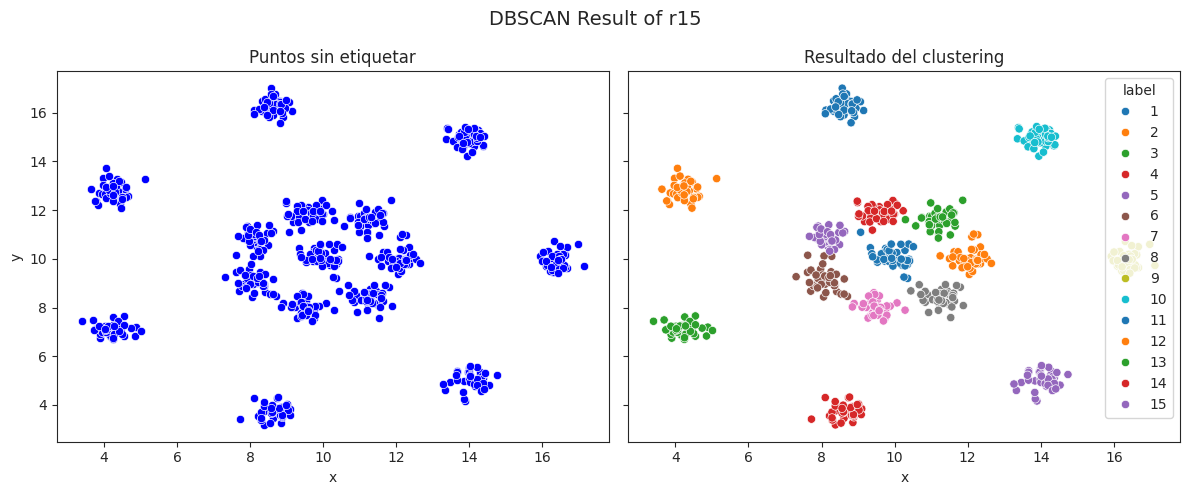

In [29]:
# Prueba con R15
test_file = 'R15.txt'
dataset = np.array(load_data_label(test_file))
print(dataset.shape)
n_partitions = (4, 2)
eps = 0.7
min_pts = 12

mdbscan = MatrixDBSCAN(dataset, eps, min_pts)
result_tags = mdbscan.predict()
print(mdbscan)
print(result_tags)
Evaluation.silhouette_coefficient(mdbscan)
del mdbscan
plot_result(dataset, result_tags, 'r15')

## Prueba de versiones paralelas con R15

In [30]:
test_file = 'R15.txt'
dataset = np.array(load_data_label(test_file))
# n_partition_set = [(2, 2), (2, 4), (4, 4)]
n_partition_set = [(2, 2)]
eps = 0.7
min_pts = 10
b_dataset = sc.broadcast(dataset)
b_eps = sc.broadcast(eps)
b_min_pts = sc.broadcast(min_pts)


Partitions: 4

NAIVE:
spatial_partition time cost: 18.845796585083008ms


predict time cost: 169.0211296081543ms
predict time cost: 154.89673614501953ms
predict time cost: 150.00200271606445ms
predict time cost: 196.7172622680664ms


merge time cost: 2.0911693572998047ms
parallel_dbscan time cost: 779.090166091919ms


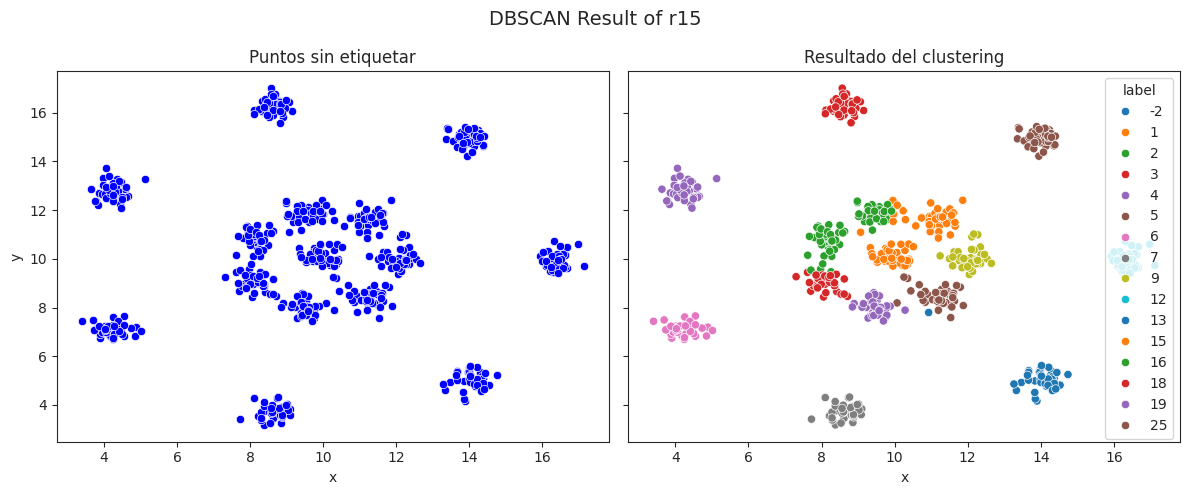


FAST-MATRIX:
spatial_partition time cost: 11.78884506225586ms


predict time cost: 85.96014976501465ms
predict time cost: 94.71678733825684ms
predict time cost: 84.07306671142578ms
predict time cost: 95.9775447845459ms


merge time cost: 1.5645027160644531ms
parallel_dbscan time cost: 380.60879707336426ms


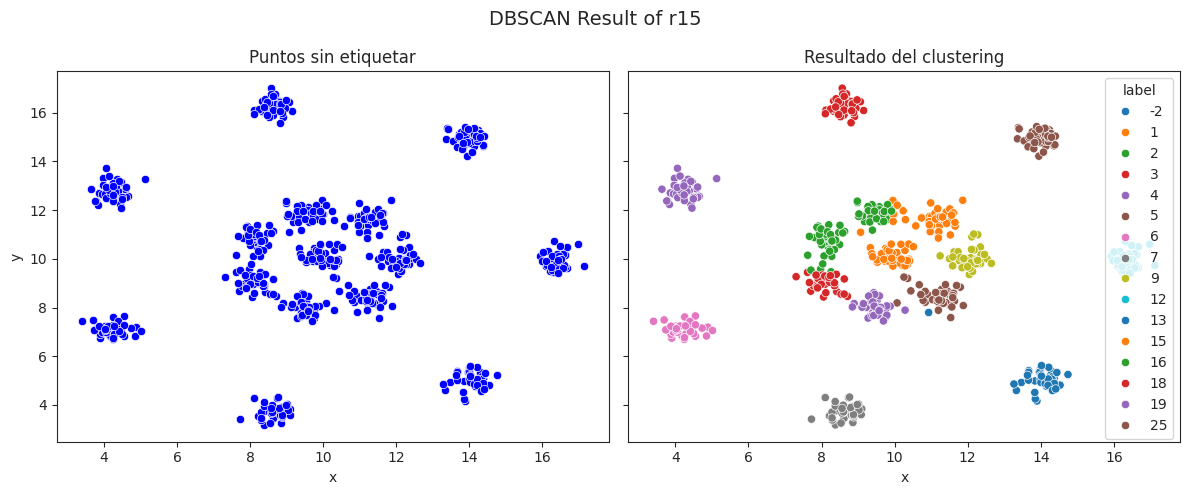


Rtree-cbs:
rtree_partition time cost: 13.633251190185547ms


predict time cost: 94.30861473083496ms
predict time cost: 96.6184139251709ms
predict time cost: 128.55958938598633ms
predict time cost: 126.00517272949219ms


merge time cost: 2.2478103637695312ms
parallel_dbscan time cost: 415.39597511291504ms


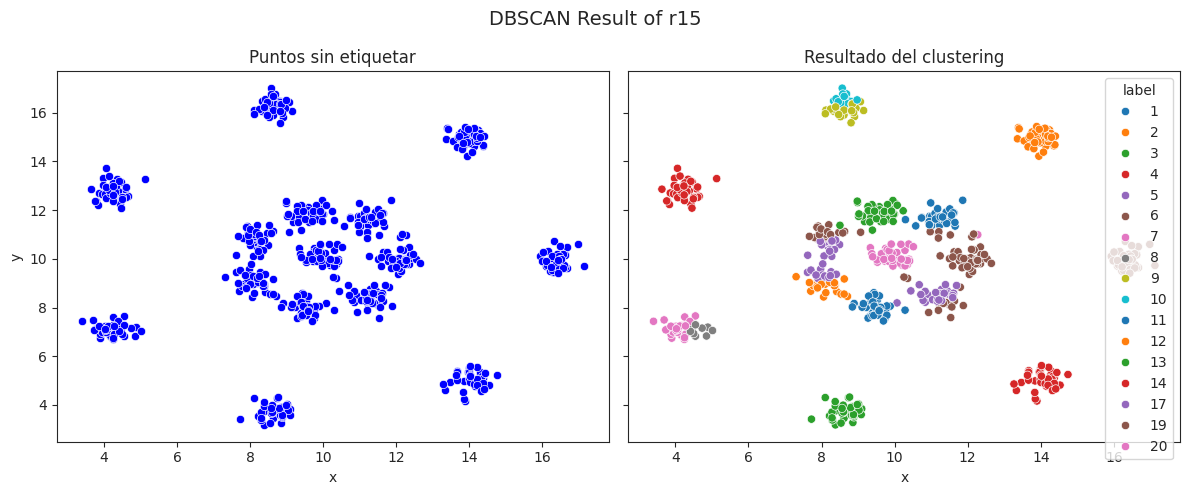


Rtree-rbs:
rtree_partition time cost: 14.140605926513672ms


predict time cost: 3.9310455322265625ms
predict time cost: 84.22994613647461ms
predict time cost: 112.11657524108887ms
predict time cost: 125.79226493835449ms


merge time cost: 1.5842914581298828ms
parallel_dbscan time cost: 417.31977462768555ms


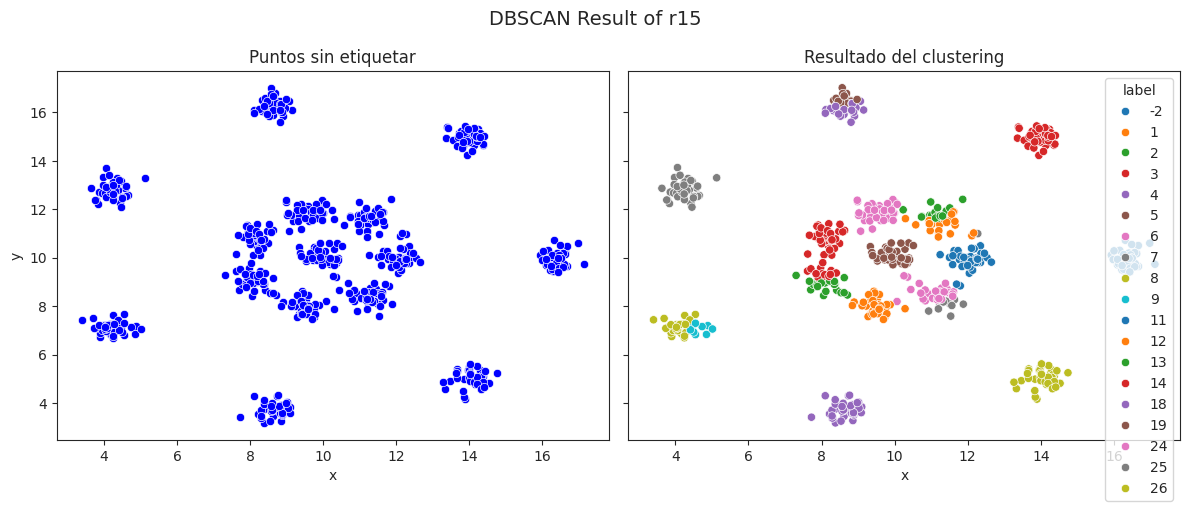

In [31]:
for tuple_par in n_partition_set:
    print(f'\nPartitions: {np.prod(tuple_par)}')
    # parallel naive dbscan
    print('\nNAIVE:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, tuple_par, method='naive', metric='euclidian')
    plot_result(dataset, result_tags, 'r15')
    # parallel matrix dbscan
    print('\nFAST-MATRIX:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, tuple_par, method='matrix', metric='fast-euclidian')
    plot_result(dataset, result_tags, 'r15')
    # Rtree cbs 
    print('\nRtree-cbs:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, tuple_par, method='matrix', metric='fast-euclidian',
                                 rtree=True, rtree_mtd='cbs')
    plot_result(dataset, result_tags, 'r15')
    # Rtree rbs
    print('\nRtree-rbs:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, tuple_par, method='matrix', metric='fast-euclidian',
                                 rtree=True, rtree_mtd='rbs')
    plot_result(dataset, result_tags, 'r15')

# Prueba con nuestros datos

In [32]:
df_sampled.show(1)

+------------------+-------------------+-------------------+-------------------+------------------+--------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+--------------------+--------------------+
|              pc_1|               pc_2|               pc_3|               pc_4|              pc_5|                pc_6|              pc_7|              pc_8|              pc_9|              pc_10|              pc_11|             pc_12|               pc_13|               pc_14|
+------------------+-------------------+-------------------+-------------------+------------------+--------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+--------------------+--------------------+
|1.0427683089756756|0.11219850947950212|-1.9879756817966643|-2.7083784351661464|1.0174389808030249|-0.12061167461774876|1.4180389246513927|0.9902431097150642|3.919

In [33]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# 1. Crear vector con los atributos numéricos
assembler = VectorAssembler(
    inputCols=df_sampled.columns,
    outputCol='features'
)
df_scaled = assembler.transform(df_numeric)

In [34]:
# Recogemos el dataset ya escalado como un array de numpy
dataset = np.array(df_scaled.select('features').rdd.map(lambda row: row['features'].toArray()).cache().collect())


In [35]:
type(dataset)

numpy.ndarray

In [36]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=123456, n_jobs=-1)
dataset_2d_tsne = tsne.fit_transform(dataset)

25/04/22 03:55:13 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [66]:
from sklearn.decomposition import PCA

dims = 14

dataset_2d = dataset

# Parámetros de clustering
# n_partition_set = [(2,)*dims]
n_partition_set = [(3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)]
eps = 3
min_pts = 30

print(n_partition_set)

# Broadcasting si lo necesitas
b_dataset = sc.broadcast(dataset_2d)
b_eps = sc.broadcast(eps)
b_min_pts = sc.broadcast(min_pts)

[(3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)]



Partitions: 12

FAST-MATRIX:
spatial_partition time cost: 192.0177936553955ms


predict time cost: 6642.836093902588ms                            (2 + 12) / 14]
predict time cost: 6952.938795089722ms                            (3 + 11) / 14]
predict time cost: 8753.551244735718ms                            (4 + 10) / 14]
predict time cost: 10377.59256362915ms                             (5 + 9) / 14]
predict time cost: 137159.72304344177ms                            (6 + 8) / 14]
predict time cost: 138757.46202468872ms>                           (7 + 7) / 14]
predict time cost: 141875.95629692078ms====>                       (8 + 6) / 14]
predict time cost: 145588.4222984314ms=========>                   (9 + 5) / 14]
predict time cost: 152553.7552833557ms============>               (10 + 4) / 14]
predict time cost: 155016.06369018555ms===============>           (11 + 3) / 14]
predict time cost: 170222.558259964ms=====================>       (12 + 2) / 14]
predict time cost: 174238.23833465576ms=======================>   (13 + 1) / 14]


merge time cost: 14028.095722198486ms
parallel_dbscan time cost: 188864.53008651733ms


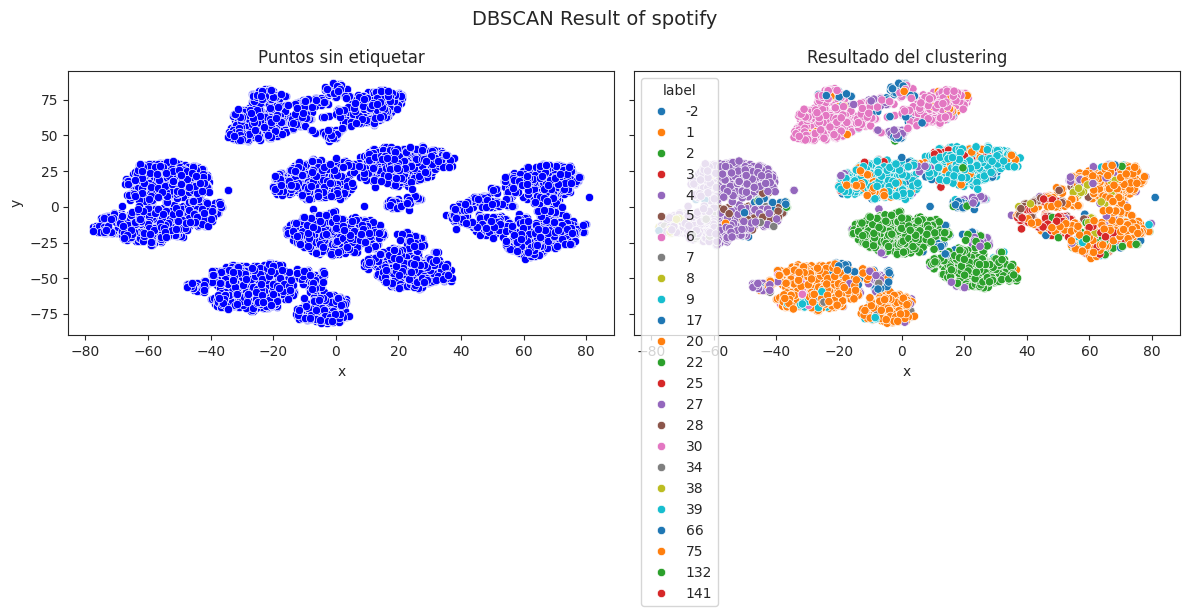

In [67]:
for tuple_par in n_partition_set:
    print(f'\nPartitions: {np.prod(tuple_par)}')
    print('\nFAST-MATRIX:')
    result_tags = parallel_dbscan(
        dataset_2d, eps, min_pts, tuple_par, method='matrix', metric='fast-euclidian')
    plot_result(dataset_2d_tsne, result_tags, 'spotify')
    """
    print('\nRtree-cbs:')
    result_tags = parallel_dbscan(dataset_2d, eps, min_pts, tuple_par, method='matrix', metric='fast-euclidian',
                                  rtree=True, rtree_mtd='cbs')
    plot_result(dataset_2d_tsne, result_tags, 'spotify')

    print('\nRtree-rbs:')
    result_tags = parallel_dbscan(dataset_2d, eps, min_pts, tuple_par,
                                  method='matrix', metric='fast-euclidian', rtree=True, rtree_mtd='rbs')
    plot_result(dataset_2d_tsne, result_tags, 'spotify')
    """


Partitions: 4

FAST-MATRIX:
spatial_partition time cost: 60.37759780883789ms


predict time cost: 9595.044374465942ms============>               (10 + 4) / 14]
predict time cost: 9695.164442062378ms
predict time cost: 9773.51427078247ms=================>           (11 + 3) / 14]
predict time cost: 12448.580265045166ms=======================>   (13 + 1) / 14]


merge time cost: 43.17426681518555ms
parallel_dbscan time cost: 12873.286008834839ms


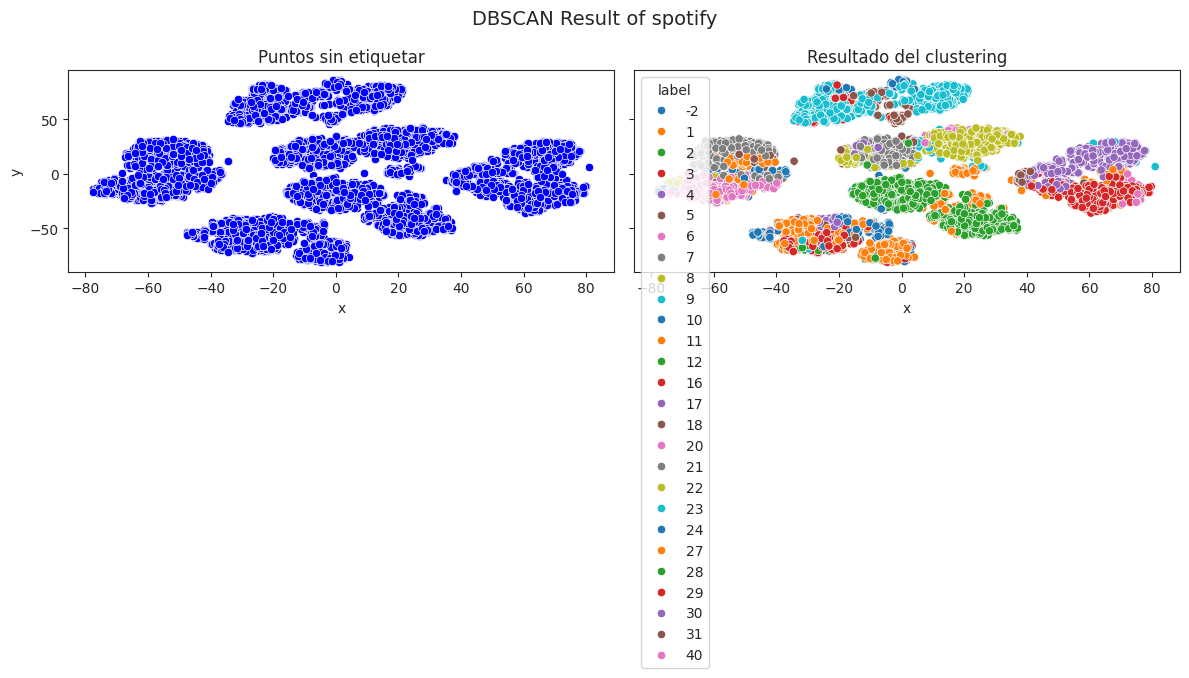


Rtree-cbs:
rtree_partition time cost: 174.4091510772705ms


predict time cost: 8986.624956130981ms============>               (10 + 4) / 14]
predict time cost: 9533.494234085083ms================>           (11 + 3) / 14]
predict time cost: 9806.655406951904ms====================>       (12 + 2) / 14]
predict time cost: 12957.880973815918ms=======================>   (13 + 1) / 14]


merge time cost: 34.55686569213867ms
parallel_dbscan time cost: 13401.310443878174ms


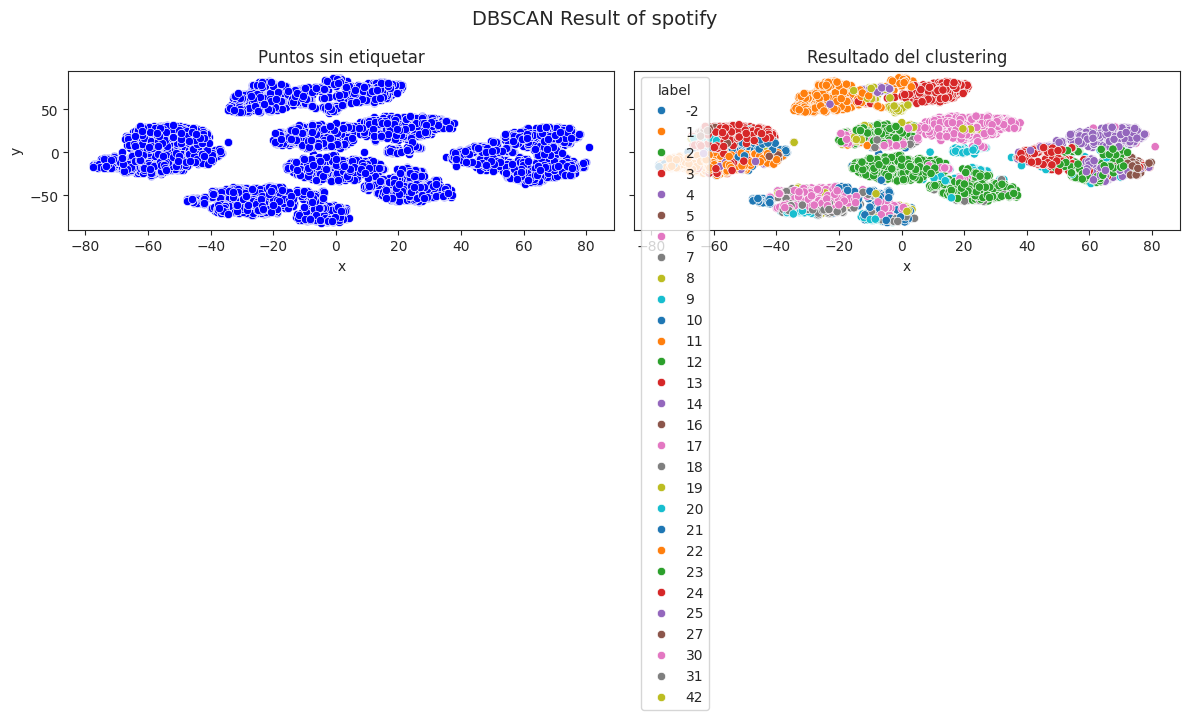


Rtree-rbs:
rtree_partition time cost: 181.304931640625ms


predict time cost: 8290.641069412231ms============>               (10 + 4) / 14]
predict time cost: 8314.984321594238ms
predict time cost: 8331.615209579468ms
predict time cost: 18592.9856300354ms=========================>   (13 + 1) / 14]


merge time cost: 43.3812141418457ms
parallel_dbscan time cost: 19080.69133758545ms


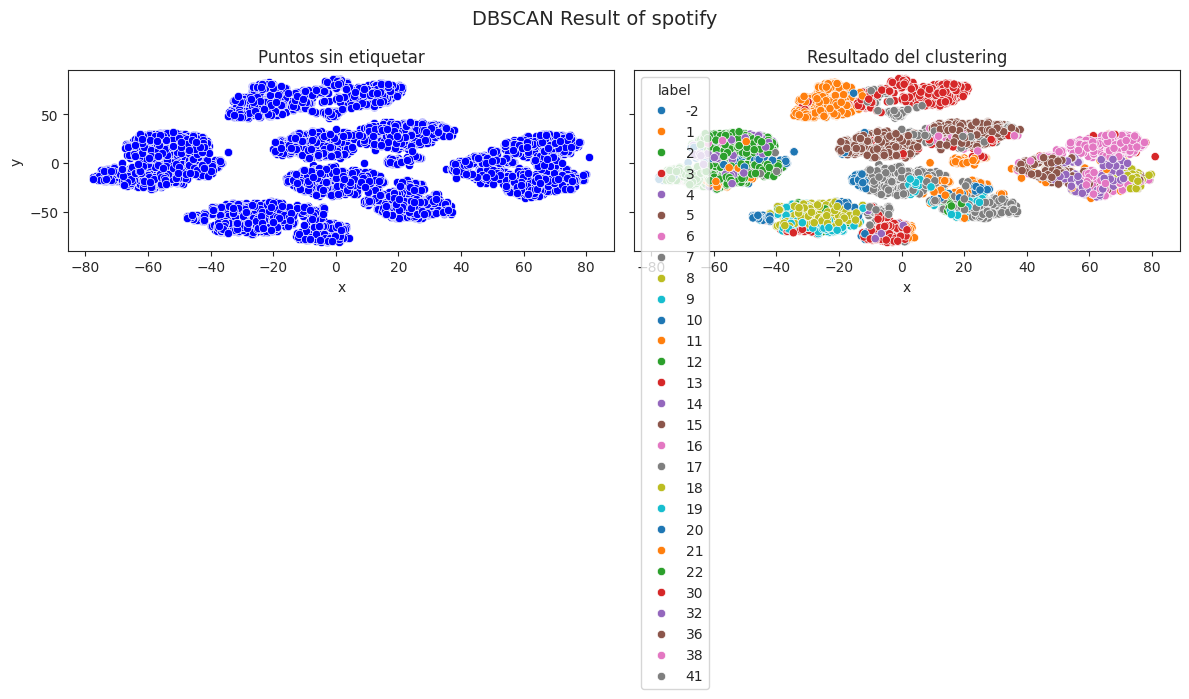

In [68]:
n_partition_set = [(2, 2)]
eps = 3
min_pts = 30

for tuple_par in n_partition_set:
    print(f'\nPartitions: {np.prod(tuple_par)}')
    print('\nFAST-MATRIX:')
    result_tags = parallel_dbscan(
        dataset_2d_tsne, eps, min_pts, tuple_par, method='matrix', metric='fast-euclidian')
    plot_result(dataset_2d_tsne, result_tags, 'spotify')

    print('\nRtree-cbs:')
    result_tags = parallel_dbscan(dataset_2d_tsne, eps, min_pts, tuple_par, method='matrix', metric='fast-euclidian',
                                  rtree=True, rtree_mtd='cbs')
    plot_result(dataset_2d_tsne, result_tags, 'spotify')

    print('\nRtree-rbs:')
    result_tags = parallel_dbscan(dataset_2d_tsne, eps, min_pts, tuple_par,
                                  method='matrix', metric='fast-euclidian', rtree=True, rtree_mtd='rbs')
    plot_result(dataset_2d_tsne, result_tags, 'spotify')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=97fa435b-89c8-4b22-a4df-60f2ff3508a1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>